# Random Forest - Top model according to the SCPM of -5.20 and dominance count 18

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "207",
    "Plant": "AT",
    "Features": "Chemical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/207/at.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [8]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [9]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [10]:
repeats = 3
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.407 (0.179)
MAE: -1.114 (0.140)
MAPE: -0.025 (0.003)
R2: 0.671 (0.166)


******
[TEST]
******
RMSE: -1.841 (0.437)
MAE: -1.494 (0.358)
MAPE: -0.033 (0.007)
R2: 0.394 (0.424)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [12]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
0,2021-01-01,41.400002,42.947492,TRAIN,CPIII40
1,2021-01-01,33.500000,35.308823,TRAIN,CPIIF32
2,2021-01-02,42.900002,44.555296,TRAIN,CPVARI
3,2021-01-04,44.900002,45.312838,TRAIN,CPVARI
4,2021-01-04,41.500000,42.947492,TRAIN,CPIII40
...,...,...,...,...,...
1720,2023-09-20,44.299999,43.628261,TEST,CPIII40
1721,2023-09-21,47.799999,46.036277,TEST,CPVARI
1722,2023-09-21,44.299999,43.245448,TEST,CPIII40
1723,2023-09-22,44.299999,43.245448,TEST,CPIII40


<IPython.core.display.Javascript object>

In [13]:
# df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# for fold, (train_index, test_index) in enumerate(cv.split(x)):
#     df_copy_merge.loc[train_index, "FOLD"] = fold + 1
#     df_copy_merge.loc[test_index, "FOLD"] = fold + 1
# df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
# df_copy_merge.to_excel("local_model_random_forest_btsscv_209_s.xlsx", index=False)
# df_copy_merge.to_csv("local_model_random_forest_btsscv_209_s.csv", index=False)

<IPython.core.display.Javascript object>

In [14]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

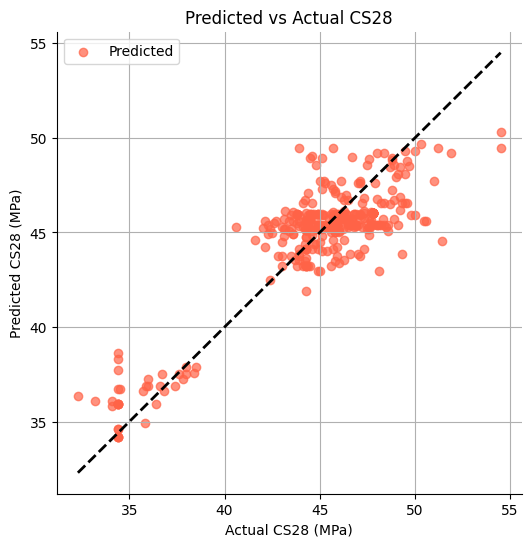

<IPython.core.display.Javascript object>

In [15]:
test_data = df_pred[df_pred["SET"] == "TEST"]

plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_207_at_cm_p_cs_btiss_scpm_top_one_random_forest_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


In [16]:
df["Cement_Type"].value_counts()

Cement_Type
CPIII40    814
CPVARI     781
CPIIF32    134
Name: count, dtype: int64

<IPython.core.display.Javascript object>

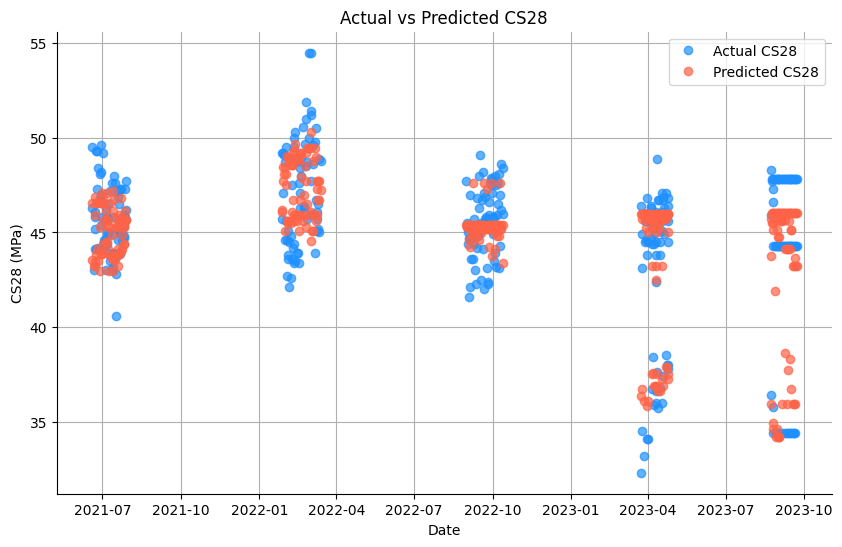

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_207_at_cm_p_cs_btiss_scpm_top_one_random_forest_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [18]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [19]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#200,#400,Specific Gravity,Initial setting time,Final setting time,CS3,CS7
Importances - 0,0.000000,0.006226,0.060307,0.000000,0.000000,0.000000,0.073641,0.000000,0.037124,0.006247,0.006209,0.008960,0.000000,0.000000,0.046686,0.010453,0.062346,0.681801
Importances - 1,0.014901,0.000000,0.014005,0.005156,0.000000,0.160575,0.047403,0.030355,0.036040,0.024501,0.008011,0.001658,0.000000,0.011045,0.039100,0.029134,0.004306,0.573808
Importances - 2,0.006781,0.199299,0.000000,0.002192,0.064297,0.028763,0.131305,0.045419,0.045932,0.000000,0.086989,0.017947,0.011049,0.049837,0.000000,0.025770,0.005460,0.278961
Importances - 3,0.046913,0.000000,0.000000,0.008105,0.009704,0.001954,0.000319,0.007450,0.724834,0.004885,0.000000,0.002483,0.000000,0.000000,0.000000,0.000000,0.147618,0.045734
Importances - 4,0.000000,0.010711,0.002996,0.000000,0.001734,0.001743,0.000000,0.003841,0.879072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014315,0.085588


<IPython.core.display.Javascript object>

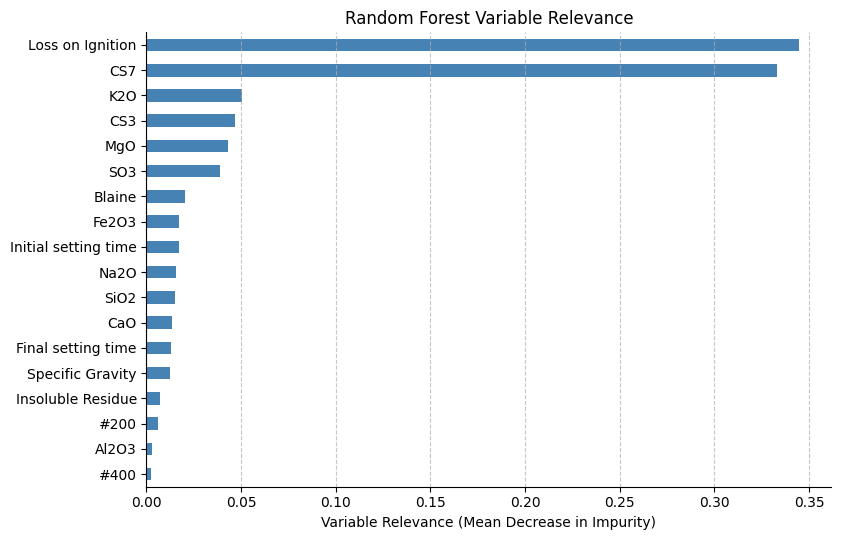

<IPython.core.display.Javascript object>

In [20]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Relevance")
plt.xlabel("Variable Relevance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

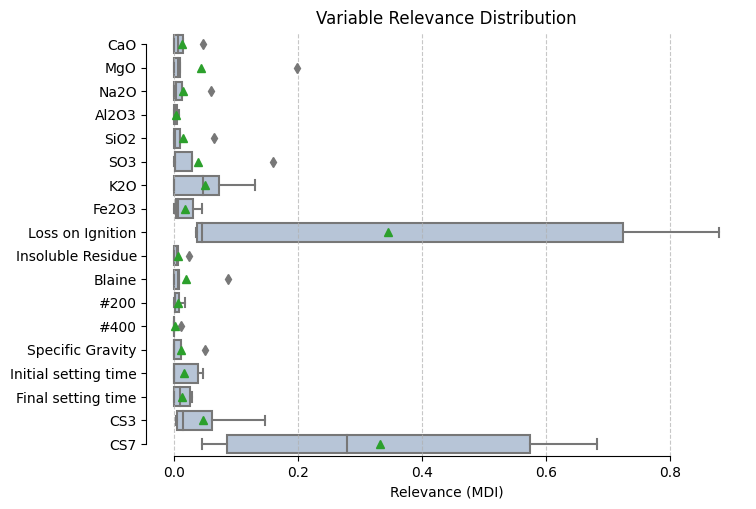

<IPython.core.display.Javascript object>

In [21]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


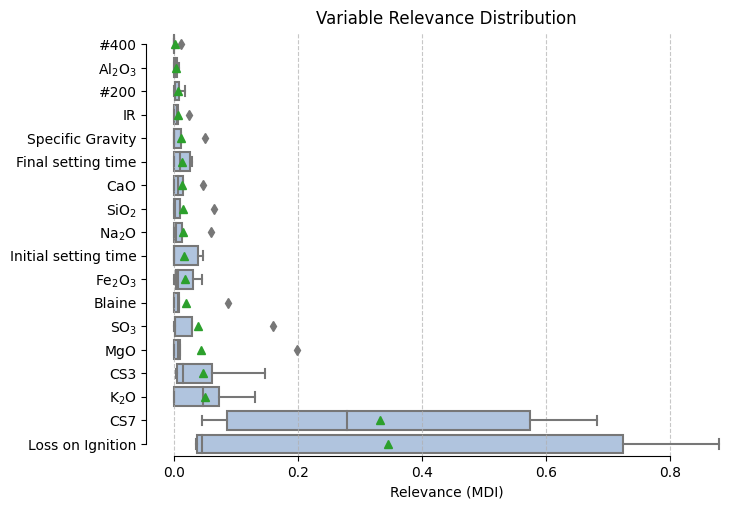

<IPython.core.display.Javascript object>

In [22]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_207_at_cm_p_cs_btiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [23]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#200,#400,Specific Gravity,Initial setting time,Final setting time,CS3,CS7
Importances - 0,0.000000,0.006226,0.060307,0.000000,0.000000,0.000000,0.073641,0.000000,0.037124,0.006247,0.006209,0.008960,0.000000,0.000000,0.046686,0.010453,0.062346,0.681801
Importances - 1,0.014901,0.000000,0.014005,0.005156,0.000000,0.160575,0.047403,0.030355,0.036040,0.024501,0.008011,0.001658,0.000000,0.011045,0.039100,0.029134,0.004306,0.573808
Importances - 2,0.006781,0.199299,0.000000,0.002192,0.064297,0.028763,0.131305,0.045419,0.045932,0.000000,0.086989,0.017947,0.011049,0.049837,0.000000,0.025770,0.005460,0.278961
Importances - 3,0.046913,0.000000,0.000000,0.008105,0.009704,0.001954,0.000319,0.007450,0.724834,0.004885,0.000000,0.002483,0.000000,0.000000,0.000000,0.000000,0.147618,0.045734
Importances - 4,0.000000,0.010711,0.002996,0.000000,0.001734,0.001743,0.000000,0.003841,0.879072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014315,0.085588


<IPython.core.display.Javascript object>

In [24]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,5.0,0.013719,0.019544,0.000000,0.000000,0.006781,0.014901,0.046913
MgO,5.0,0.043247,0.087353,0.000000,0.000000,0.006226,0.010711,0.199299
Na2O,5.0,0.015462,0.025723,0.000000,0.000000,0.002996,0.014005,0.060307
Al2O3,5.0,0.003091,0.003511,0.000000,0.000000,0.002192,0.005156,0.008105
SiO2,5.0,0.015147,0.027767,0.000000,0.000000,0.001734,0.009704,0.064297
SO3,5.0,0.038607,0.069221,0.000000,0.001743,0.001954,0.028763,0.160575
K2O,5.0,0.050534,0.055097,0.000000,0.000319,0.047403,0.073641,0.131305
Fe2O3,5.0,0.017413,0.019612,0.000000,0.003841,0.007450,0.030355,0.045419
Loss on Ignition,5.0,0.344600,0.421068,0.036040,0.037124,0.045932,0.724834,0.879072
Insoluble Residue,5.0,0.007127,0.010115,0.000000,0.000000,0.004885,0.006247,0.024501


<IPython.core.display.Javascript object>

In [25]:
df_importances.mean(axis=0)

CaO                     0.013719
MgO                     0.043247
Na2O                    0.015462
Al2O3                   0.003091
SiO2                    0.015147
SO3                     0.038607
K2O                     0.050534
Fe2O3                   0.017413
Loss on Ignition        0.344600
Insoluble Residue       0.007127
Blaine                  0.020242
#200                    0.006210
#400                    0.002210
Specific Gravity        0.012176
Initial setting time    0.017157
Final setting time      0.013072
CS3                     0.046809
CS7                     0.333179
dtype: float64

<IPython.core.display.Javascript object>

In [26]:
df_importances.std(axis=0, ddof=0)

CaO                     0.017480
MgO                     0.078131
Na2O                    0.023008
Al2O3                   0.003141
SiO2                    0.024836
SO3                     0.061913
K2O                     0.049281
Fe2O3                   0.017541
Loss on Ignition        0.376614
Insoluble Residue       0.009047
Blaine                  0.033530
#200                    0.006610
#400                    0.004420
Specific Gravity        0.019310
Initial setting time    0.021150
Final setting time      0.012392
CS3                     0.054728
CS7                     0.255462
dtype: float64

<IPython.core.display.Javascript object>

In [27]:
df_copy.nunique()

Date                    844
CaO                     632
MgO                     211
Na2O                     12
Al2O3                   297
SiO2                    591
SO3                     205
K2O                      49
Fe2O3                   182
Loss on Ignition        414
Insoluble Residue       191
Blaine                  142
#200                     34
#400                     78
Specific Gravity         21
Initial setting time     54
Final setting time       56
CS3                     224
CS7                     199
dtype: int64

<IPython.core.display.Javascript object>

In [28]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'estimator': RandomForestRegressor(max_depth=3, n_estimators=5, random_state=47)}

<IPython.core.display.Javascript object>

In [29]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [30]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        imputer.transform(x.iloc[test_idx]),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

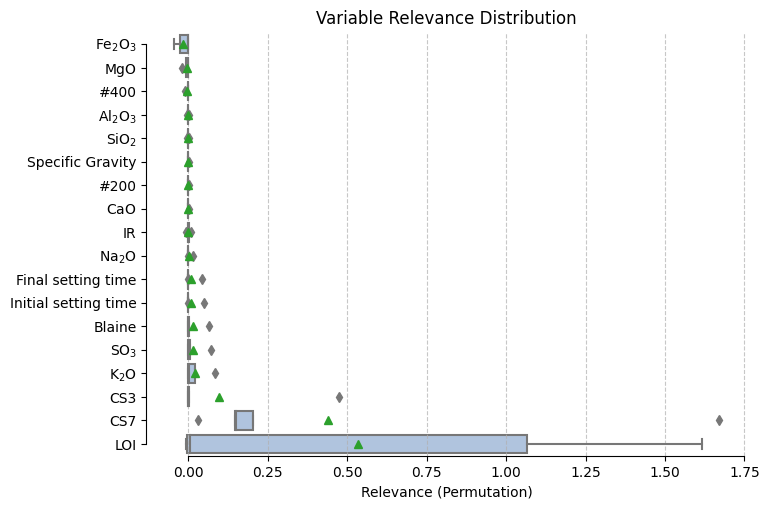

<IPython.core.display.Javascript object>

In [31]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "TiO2": r"$\mathrm{TiO_2}$",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_207_at_cm_p_cs_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [32]:
perm_importances_df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Fe2O3,5.0,-0.01,0.02,-0.05,-0.03,-0.00,-0.00,0.00
MgO,5.0,-0.00,0.01,-0.02,-0.01,0.00,0.00,0.00
#400,5.0,-0.00,0.00,-0.01,0.00,0.00,0.00,0.00
Al2O3,5.0,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00
SiO2,5.0,0.00,0.00,-0.00,0.00,0.00,0.00,0.00
Specific Gravity,5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
#200,5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
CaO,5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Insoluble Residue,5.0,0.00,0.01,-0.01,0.00,0.00,0.00,0.01
Na2O,5.0,0.00,0.01,-0.00,0.00,0.00,0.00,0.02


<IPython.core.display.Javascript object>

In [33]:
perm_importances_df

,Fe2O3,MgO,#400,Al2O3,SiO2,Specific Gravity,#200,CaO,Insoluble Residue,Na2O,Final setting time,Initial setting time,Blaine,SO3,K2O,CS3,CS7,LOI
0,0.000000,-0.006363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.006140,0.000000,-0.001493,-0.000544,0.002273,0.000000,0.021371,0.474476,1.670486,-0.007359
1,-0.045146,0.000000,0.000000,-0.004603,0.000000,0.000097,0.000321,0.003951,0.002693,0.016120,0.043818,0.050608,0.000064,0.071377,0.085892,0.000580,0.204764,0.006353
2,-0.026807,-0.018315,-0.010561,0.000000,-0.003071,0.001741,0.000000,0.000504,0.000000,0.000000,0.000000,0.000000,0.067251,0.000000,0.000000,0.000000,0.146178,-0.003314
3,-0.001264,0.000000,0.000000,0.003066,0.000005,0.000000,0.004104,0.000013,0.008553,0.000000,0.000000,0.000000,0.000000,0.006338,0.001729,0.003261,0.031119,1.616139
4,-0.001065,0.000000,0.000000,0.000000,0.003677,0.000000,0.000000,0.000000,0.000000,-0.000181,0.000000,0.000000,0.000000,0.001623,0.000000,0.000278,0.150834,1.067489


<IPython.core.display.Javascript object>

In [34]:
perm_importances_df.mean(axis=0)

Fe2O3                  -0.014856
MgO                    -0.004936
#400                   -0.002112
Al2O3                  -0.000307
SiO2                    0.000122
Specific Gravity        0.000368
#200                    0.000885
CaO                     0.000893
Insoluble Residue       0.001021
Na2O                    0.003188
Final setting time      0.008465
Initial setting time    0.010013
Blaine                  0.013918
SO3                     0.015868
K2O                     0.021798
CS3                     0.095719
CS7                     0.440676
LOI                     0.535861
dtype: float64

<IPython.core.display.Javascript object>

In [35]:
perm_importances_df.std(axis=0, ddof=0)

Fe2O3                   0.018199
MgO                     0.007129
#400                    0.004224
Al2O3                   0.002454
SiO2                    0.002139
Specific Gravity        0.000688
#200                    0.001614
CaO                     0.001541
Insoluble Residue       0.004752
Na2O                    0.006466
Final setting time      0.017686
Initial setting time    0.020299
Blaine                  0.026681
SO3                     0.027852
K2O                     0.033049
CS3                     0.189382
CS7                     0.617505
LOI                     0.680559
dtype: float64

<IPython.core.display.Javascript object>